In [25]:
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump, load
from tabulate import tabulate
import numpy as np
import pandas as pd
import re
import string
import unicodedata
import nltk

# Baixa recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ghans\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# Carrega o conjunto de dados
dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")

# Mostra o tamanho do dataset original
print("Tamanho do dataset original:", dataset.shape[0], "\n")

# Remove linhas com valores em branco
dataset = dataset.dropna(subset=['review_text', 'overall_rating'])

# Mostra o tamanho do dataset alterado
print("Tamanho do dataset alterado:", dataset.shape[0], "\n")


Tamanho do dataset original: 132373 

Tamanho do dataset alterado: 129098 



C:\Users\ghans\AppData\Local\Temp\ipykernel_4004\3311458984.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv("C:\\fatec\\B2W-Reviews01\\B2W-Reviews01.csv")


In [17]:
# Cria uma nova coluna para classificar entre comentários positivos, negativos ou neutros com base na nota:
dataset['feeling'] = np.where(dataset['overall_rating'] < 3, 'Negative', np.where(dataset['overall_rating'] == 3, 'Neutral', 'Positive'))

# Mostra os primeiros registros do dataset
print("Primeiros registros do dataset:")
print(tabulate(dataset.head(20), headers='keys', tablefmt='pipe'))

Primeiros registros do dataset:
|    | submission_date     | reviewer_id                                                      |   product_id | product_name                                                                                                                   | product_brand   | site_category_lv1       | site_category_lv2             | review_title                     |   overall_rating | recommend_to_a_friend   | review_text                                                                                                                                                                                                                                                         |   reviewer_birth_year | reviewer_gender   | reviewer_state   | feeling   |
|---:|:--------------------|:-----------------------------------------------------------------|-------------:|:----------------------------------------------------------------------------------------------------------------------------

In [18]:
# Pré-processamento dos dados
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))

preprocessed_texts = []  # Lista para armazenar os textos pré-processados

# Itera sobre cada texto no dataset para pré-processamento
for text in dataset['review_text']:
    if isinstance(text, str):  # Verifica se o texto é uma string
        # Converter para minúsculas
        text = text.lower()
        # Remover acentos
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if unicodedata.category(char) != 'Mn')
        # Remover números usando expressão regular
        text = re.sub(r'\d+', '', text)
        # Remover caracteres especiais (incluindo emojis)
        text = re.sub(r'[^\w\s]', '', text)
        # Remover pontuação
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remover espaços extras
        text = re.sub(r'\s+', ' ', text).strip()
        # Tokenização
        tokens = word_tokenize(text)
        # Lematização e remoção de stopwords
        tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word.lower() not in stop_words]
        # Juntar tokens em texto novamente
        preprocessed_text = ' '.join(tokens)
        preprocessed_texts.append(preprocessed_text)  # Adicionar texto pré-processado à lista
    else:
        preprocessed_texts.append("")

# Atualiza o DataFrame com os textos pré-processados
dataset['review_text'] = preprocessed_texts

# Mostra o dataset após o pré-processamento
print("\nDataset após pré-processamento:")
print(tabulate(dataset.head(20), headers='keys', tablefmt='pipe'))



Dataset após pré-processamento:
|    | submission_date     | reviewer_id                                                      |   product_id | product_name                                                                                                                   | product_brand   | site_category_lv1       | site_category_lv2             | review_title                     |   overall_rating | recommend_to_a_friend   | review_text                                                                                                                                                                                        |   reviewer_birth_year | reviewer_gender   | reviewer_state   | feeling   |
|---:|:--------------------|:-----------------------------------------------------------------|-------------:|:-------------------------------------------------------------------------------------------------------------------------------|:----------------|:------------------------|:---------------

In [19]:
# Separar os dados em features (X) e target (Y)
X = dataset['review_text'].values
Y = dataset['feeling'].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [20]:
# Função para análise de sentimento utilizando TextBlob com threshold ajustável
def analyze_sentiment(text, threshold=0):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > threshold:
        return 'Positive'
    elif sentiment < -threshold:
        return 'Negative'
    else:
        return 'Neutral'

# Aplica a função de análise de sentimento ao conjunto de teste com threshold de 0.2
Y_pred = [analyze_sentiment(text, threshold=0.2) for text in X_test]

# Avalia a acurácia do modelo
accuracy = np.mean(Y_pred == Y_test)
print("\nAcurácia:", accuracy)

# Mostra as previsões e as verdadeiras classes de 'feeling'
df_results = pd.DataFrame({'Feeling_Predicted': Y_pred, 'Feeling_True': Y_test})
print("\nResultados de 'feeling' após a análise de sentimento com threshold ajustável:")
print(df_results.head(20))  # Exibir os 20 primeiros registros



Acurácia: 0.20395042602633617

Resultados de 'feeling' após a análise de sentimento com threshold ajustável:
   Feeling_Predicted Feeling_True
0           Positive     Positive
1            Neutral     Positive
2            Neutral      Neutral
3            Neutral     Negative
4            Neutral     Positive
5            Neutral     Positive
6            Neutral     Negative
7            Neutral      Neutral
8            Neutral     Positive
9            Neutral     Positive
10           Neutral     Positive
11          Positive     Positive
12          Positive     Positive
13           Neutral     Negative
14          Positive     Positive
15           Neutral     Positive
16           Neutral     Positive
17           Neutral     Positive
18           Neutral      Neutral
19           Neutral     Positive


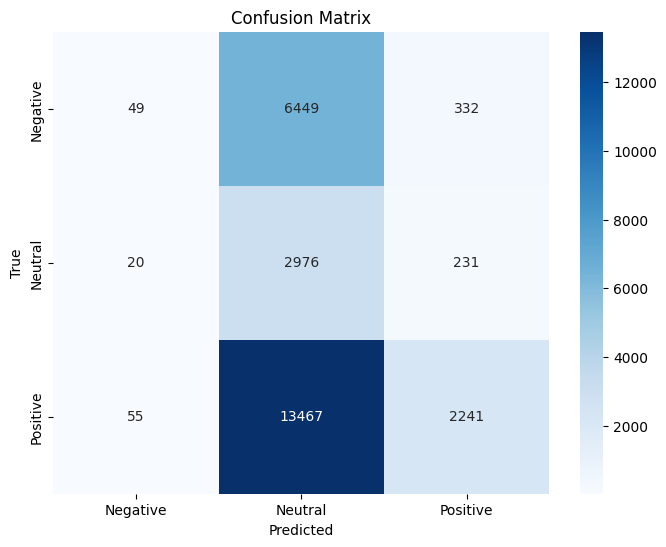

In [21]:
# Cria a matriz de confusão
conf_matrix = confusion_matrix(Y_test, Y_pred, labels=['Negative', 'Neutral', 'Positive'])

# Cria um DataFrame para facilitar a visualização
df_conf_matrix = pd.DataFrame(conf_matrix, index=['Negative', 'Neutral', 'Positive'], columns=['Negative', 'Neutral', 'Positive'])

# Plota a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(df_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Salva o modelo em um arquivo, no mesmo diretório deste notebook
dump(analyze_sentiment, 'sentiment_model_textblob.joblib')

['sentiment_model_textblob.joblib']